In [35]:
import torch
import torchvision
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from livelossplot import PlotLosses
from sklearn.metrics import top_k_accuracy_score

In [36]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("../data/said_to_actions.csv") 
data["interaction"] = 1
data = pd.pivot_table(data, index="user_id", columns="car_id", values="interaction").reset_index().rename_axis(None, axis=1)
data = data.fillna(0)
data = data.rename(columns={"user_id":"userId"})

test_split = 0.2

train_data, test_data = data.iloc[:int(len(data) * (1-test_split))], data.iloc[:int(len(data) * test_split)]
train_data.to_csv("../data/pivot_actions_train.csv", index=False)
test_data.to_csv("../data/pivot_actions_test.csv", index=False)

In [37]:
data

,userId,1,10,100,101,102,103,104,105,106,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,497.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,498.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
pd.read_csv("../data/dataset.csv").car_id.nunique()

109

In [39]:
train_data

,userId,1,10,100,101,102,103,104,105,106,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,396.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
397,397.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
class TrainDataset(Dataset):
    def __init__(self, train_file, transform=None):
        self.data = pd.read_csv(train_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        
        if transform is not None:
            self.data = self.transform(np.array(self.data))
        
    def __len__(self):
        return len(self.data[0])
    
    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        
        return user_vector


class TestDataset(Dataset):
    def __init__(self, test_file, transform=None):
        self.data = pd.read_csv(test_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        
        if transform is not None:
            self.data = self.transform(np.array(self.data))
        
    def __len__(self):
        return len(self.data[0])
    
    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        
        return user_vector

In [41]:
transformations = transforms.Compose([transforms.ToTensor()])
train_dat = TrainDataset('../data/pivot_actions_train.csv', transformations)

In [42]:
print("Training Length: ", train_dat.__len__())
print("6th User Ratings: ", train_dat.__getitem__(7))

Training Length:  400
6th User Ratings:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,

In [43]:
train_dat[1]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 

In [44]:
test_dat = TestDataset('../data/pivot_actions_test.csv', transformations)

In [45]:
print("Testing Length: ", test_dat.__len__())
print("6th User Ratings: ", test_dat.__getitem__(4))

Testing Length:  100
6th User Ratings:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


## Dataloader

In [46]:
train_dl = DataLoader(dataset=train_dat, batch_size = 128, shuffle=True, num_workers = 1)

In [47]:
test_dl = DataLoader(dataset=test_dat, batch_size=128, shuffle=True, num_workers=1)

In [48]:
next(iter(train_dl)).size()

torch.Size([128, 403])

In [49]:
# Checking for availability of GPU

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## Training the Model

In [50]:
data.shape

(500, 404)

### Loss and Optimizer

In [51]:
# Loss Function
class MSEloss_with_Mask(nn.Module):
  def __init__(self):
    super(MSEloss_with_Mask,self).__init__()

  def forward(self,inputs, targets):
    # Masking into a vector of 1's and 0's.
    mask = (targets!=0)
    mask = mask.float()

    # Actual number of ratings.
    # Take max to avoid division by zero while calculating loss.
    other = torch.Tensor([1.0])
    other = other.cuda()
    number_ratings = torch.max(torch.sum(mask),other)
    error = torch.sum(torch.mul(mask,torch.mul((targets-inputs),(targets-inputs))))
    loss = error.div(number_ratings)
    return loss[0]
  
criterion = MSEloss_with_Mask()
criterion = criterion.cuda()

### Model

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


def activation(input, type):
  
    if type.lower()=='selu':
        return F.selu(input)
    elif type.lower()=='elu':
        return F.elu(input)
    elif type.lower()=='relu':
        return F.relu(input)
    elif type.lower()=='relu6':
        return F.relu6(input)
    elif type.lower()=='lrelu':
        return F.leaky_relu(input)
    elif type.lower()=='tanh':
        return F.tanh(input)
    elif type.lower()=='sigmoid':
        return F.sigmoid(input)
    elif type.lower()=='swish':
        return F.sigmoid(input)*input
    elif type.lower()=='identity':
        return input
    else:
        raise ValueError("Unknown non-Linearity Type")


class AutoEncoder(nn.Module):

    def __init__(self, layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=True):
        """
        layer_sizes = size of each layer in the autoencoder model
        For example: [10000, 1024, 512] will result in:
            - encoder 2 layers: 10000x1024 and 1024x512. Representation layer (z) will be 512
            - decoder 2 layers: 512x1024 and 1024x10000.
        
        nl_type = non-Linearity type (default: 'selu).
        is_constrained = If true then the weights of encoder and decoder are tied.
        dp_drop_prob = Dropout probability.
        last_layer_activations = Whether to apply activation on last decoder layer.
        """

        super(AutoEncoder, self).__init__()

        self.layer_sizes = layer_sizes
        self.nl_type = nl_type
        self.is_constrained = is_constrained
        self.dp_drop_prob = dp_drop_prob
        self.last_layer_activations = last_layer_activations

        if dp_drop_prob>0:
            self.drop = nn.Dropout(dp_drop_prob)

        self._last = len(layer_sizes) - 2

        # Initaialize Weights
        self.encoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(layer_sizes[i+1], layer_sizes[i])) for i in range(len(layer_sizes) - 1)  ] )

        # "Xavier Initialization" ( Understanding the Difficulty in training deep feed forward neural networks - by Glorot, X. & Bengio, Y. )
        # ( Values are sampled from uniform distribution )
        for weights in self.encoder_weights:
            init.xavier_uniform_(weights)

        # Encoder Bias
        self.encoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(layer_sizes[i+1])) for i in range(len(layer_sizes) - 1) ] )

        reverse_layer_sizes = list(reversed(layer_sizes)) 
        # reversed returns iterator


        # Decoder Weights
        if is_constrained == False:
            self.decoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(reverse_layer_sizes[i+1], reverse_layer_sizes[i])) for i in range(len(reverse_layer_sizes) - 1) ] )

            for weights in self.decoder_weights:
                init.xavier_uniform_(weights)

        self.decoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(reverse_layer_sizes[i+1])) for i in range(len(reverse_layer_sizes) - 1) ] )



    def encode(self,x):
        for i,w in enumerate(self.encoder_weights):
            x = F.linear(input=x, weight = w, bias = self.encoder_bias[i] )
            x = activation(input=x, type=self.nl_type)

        # Apply Dropout on the last layer
        if self.dp_drop_prob > 0:
            x = self.drop(x)

        return x


    def decode(self,x):
        if self.is_constrained == True:
            # Weights are tied
            for i,w in zip(range(len(self.encoder_weights)),list(reversed(self.encoder_weights))):
                x = F.linear(input=x, weight=w.t(), bias = self.decoder_bias[i] )
                x = activation(input=x, type=self.nl_type if i != self._last or self.last_layer_activations else 'identity')

        else:

            for i,w in enumerate(self.decoder_weights):
                x = F.linear(input=x, weight = w, bias = self.decoder_weights[i])
                x = activation(input=x, type=self.nl_type if i != self._last or self.last_layer_activations else 'identity')

        return x

    def forward(self,x):
        # Forward Pass
        return self.decode(self.encode(x))



In [53]:
layer_sizes = [train_data.shape[1]-1, 512, 512, 1024]

In [54]:
model = AutoEncoder(layer_sizes=layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=False)

In [55]:
model = model.cuda()

In [56]:
# Optimizer

# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-6, momentum = 0.9, nesterov = True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Fitting the Model

In [57]:
# hl1_tr_loss = []
# hl2_val_loss = []

In [58]:
hl1_tr_loss = []
hl2_val_loss = []

In [59]:
def train(model, criterion, optimizer, train_dl, test_dl, num_epochs=40):
  # We will run for 40 epochs
  liveloss = PlotLosses()
  for epoch in range(num_epochs):
    train_loss, valid_loss = [], []
    train_rmse_loss, valid_rmse_loss = [], []
    
    logs = {}
    prefix = ''

    # Training Part
    model.train()
    for i, data in enumerate(train_dl, 0):
      # Get the inputs
      inputs = labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()

      inputs = inputs.float()
      labels = labels.float()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      outputs = outputs.cuda()
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()

      ## -> Iterative Dense Output Re-feeding <- ##
      
      # Add a "for" loop to iterate as much you want
      
      # Zero the gradiants
      optimizer.zero_grad()
      
      # Important -> detach() the output, to avoid unecessary construction of 
      # the computational graph
      outputs = model(outputs.detach())
      outputs = outputs.cuda()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      rmse_loss = np.sqrt(loss.item())
      train_rmse_loss.append(rmse_loss)
      logs[prefix + 'MRMSE loss'] = rmse_loss

      train_loss.append(loss.item())
      logs[prefix + 'MMSE loss'] = loss.item()

    for i, data in enumerate(test_dl, 0):
      model.eval()
      inputs = labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()

      inputs = inputs.float()
      labels = labels.float()

      outputs = model(inputs)
      outputs = outputs.cuda()
      loss = criterion(outputs, labels)
      rmse_loss = np.sqrt(loss.item())
      valid_rmse_loss.append(rmse_loss)
      valid_loss.append(loss.item())
      prefix = 'val_'
      logs[prefix + 'MMSE loss'] = loss.item()
      logs[prefix + 'MRMSE loss'] = rmse_loss

    hl1_tr_loss.append(np.mean(train_loss))
    hl2_val_loss.append(np.mean(valid_loss))
    liveloss.update(logs)
    liveloss.draw()
    print ("Epoch:", epoch+1, " Training Loss: ", np.mean(train_loss), " Valid Loss: ", np.mean(valid_loss), "Train RMSE Loss: ", np.mean(valid_rmse_loss), "Valid RMSE Loss: ", np.mean(valid_rmse_loss))
    if epoch == num_epochs -1:
      return outputs

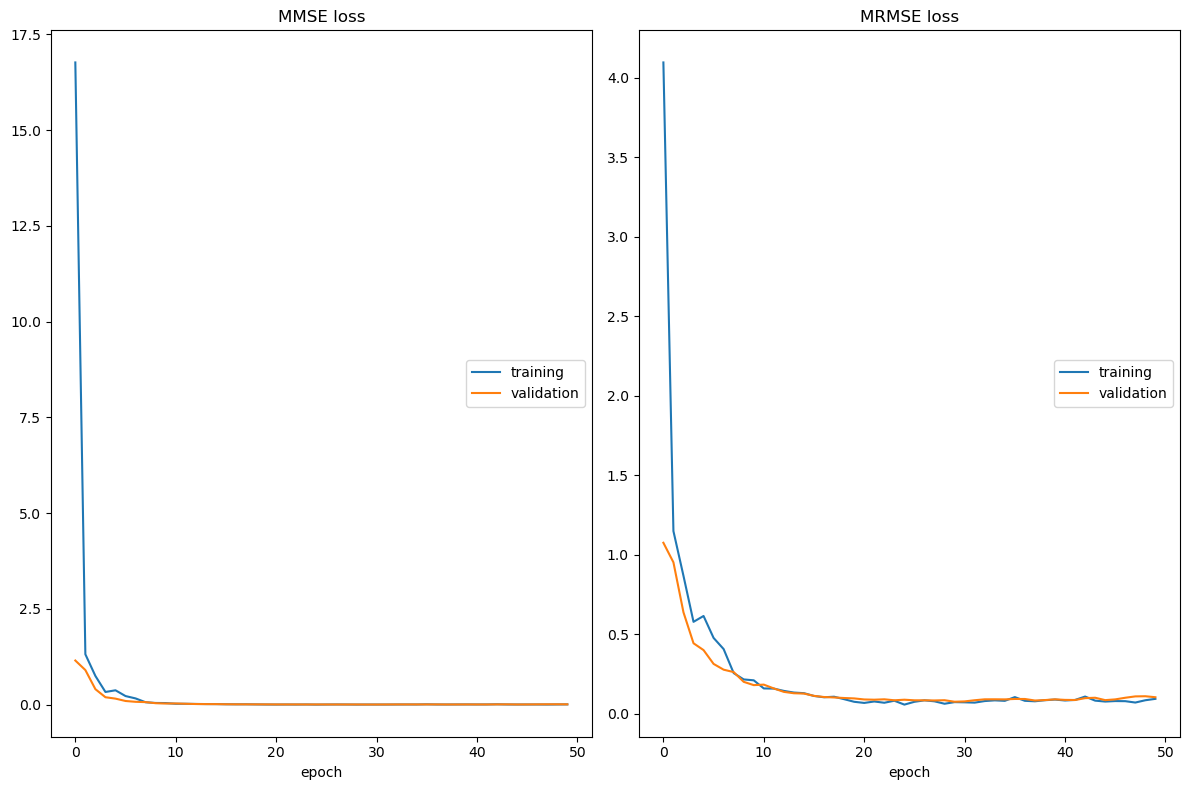

MMSE loss
	training         	 (min:    0.003, max:   16.768, cur:    0.009)
	validation       	 (min:    0.006, max:    1.154, cur:    0.011)
MRMSE loss
	training         	 (min:    0.057, max:    4.095, cur:    0.093)
	validation       	 (min:    0.075, max:    1.074, cur:    0.103)
Epoch: 50  Training Loss:  0.014476186130195856  Valid Loss:  0.010651957243680954 Train RMSE Loss:  0.10320831964372326 Valid RMSE Loss:  0.10320831964372326


In [60]:
out = train(model, criterion, optimizer, train_dl, test_dl, 50)

In [69]:
# Input Batch

test_batch = next(iter(test_dl)).to("cuda").float()

In [70]:
test_batch[0].nonzero()

tensor([[ 23],
        [ 88],
        [185],
        [233],
        [255],
        [287],
        [364],
        [375]], device='cuda:0')

In [63]:
test_batch[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [64]:
torch.sigmoid(model(test_batch[0]).cpu().detach())

tensor([0.7121, 0.7073, 0.7008, 0.6999, 0.7061, 0.6589, 0.6911, 0.6986, 0.6458,
        0.6288, 0.6983, 0.6486, 0.7477, 0.6432, 0.7176, 0.6774, 0.7218, 0.6961,
        0.6772, 0.6685, 0.6561, 0.6564, 0.7438, 0.7131, 0.6917, 0.7079, 0.7031,
        0.7279, 0.7098, 0.6825, 0.6192, 0.7169, 0.7466, 0.7009, 0.6202, 0.6641,
        0.7237, 0.6780, 0.7418, 0.6901, 0.7328, 0.7056, 0.4540, 0.7912, 0.7061,
        0.7210, 0.6262, 0.6728, 0.7199, 0.7171, 0.7064, 0.7010, 0.6734, 0.6319,
        0.7184, 0.6627, 0.7300, 0.6866, 0.5760, 0.6962, 0.7482, 0.6530, 0.7037,
        0.6924, 0.7195, 0.7207, 0.7243, 0.7214, 0.6932, 0.7449, 0.6992, 0.6668,
        0.6658, 0.7019, 0.7342, 0.7341, 0.6755, 0.6644, 0.7230, 0.7272, 0.6823,
        0.9477, 0.6663, 0.7070, 0.7373, 0.6884, 0.6964, 0.6803, 0.7097, 0.7040,
        0.7182, 0.6886, 0.6453, 0.7118, 0.6464, 0.6690, 0.7526, 0.7182, 0.6991,
        0.7152, 0.6494, 0.6910, 0.7008, 0.6366, 0.6664, 0.7135, 0.6919, 0.6928,
        0.6570, 0.6640, 0.7135, 0.6667, 

In [65]:
def top_n_accuracy(predictions, test_data, top_n):
    """
    Calculates the top-N recommendation accuracy.

    Parameters:
    predictions (numpy array): predicted ratings for all users and items.
    test_data (numpy array): test data with user-item interactions.
    top_n (int): number of top items to consider.

    Returns:
    accuracy (float): top-N recommendation accuracy.
    """
    # get the indices of the top-N items for each user in the test data
    test_top_n = np.apply_along_axis(lambda x: np.argsort(x)[-top_n:], axis=1, arr=test_data)

    # get the indices of the recommended items for each user
    pred_indices = np.argsort(predictions, axis=1)[:,::-1][:,:top_n]

    # calculate the number of correctly recommended items for each user
    correct = np.zeros(predictions.shape[0])
    for i in range(predictions.shape[0]):
        correct[i] = len(np.intersect1d(test_top_n[i], pred_indices[i]))

    # calculate top-N recommendation accuracy
    accuracy = np.mean(correct / top_n)

    return accuracy

# define test_batch and model before calling the function
test_batch = next(iter(test_dl)).to("cuda").float()
model_predictions = torch.sigmoid(model(test_batch).detach().cpu()).numpy()
test_batch = test_batch.cpu().detach().numpy() 

k = 50
accuracy = top_n_accuracy(model_predictions, test_batch, k)
print(f"Top-{k} accuracy:", accuracy)


Top-50 accuracy: 0.21100000000000002


In [66]:
import plotly.express as px

px.imshow(test_batch)

In [67]:
px.imshow(model_predictions)

In [68]:
torch.save(model.state_dict(), "../weights/autoencoder.pth")

So, we can conclude that the **output is Dense**, whereas the **input given to the model is sparse**. Thus we have succeeded in developing state-of-the-art technique in order to predict user ratings.